# Openmc Overview

The purpose of this notebook is to provide an introduction to the capabilities of OpenMC.  The coverage is intended to provide a fairly deep look at a geometrically simple problem of an infinite pin-cell. The basic topics to be covered will be:

1. material specification
2. geometry description
3. tally specification
4. control parameter specification

The analysis will include a simple criticality calculation and neutron flux energy spectrum measurement.  This will be followed by a somewhat more elaborate treatment of fuel material specification and some exploration into the consequences of one or two important details of fuel material composition.  A burn-up analysis will also be conducted to demonstrate the code capabilities and get a first look at the evolution of important fission products.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import math
import openmc

## Material Specification

First we will define the fuel

In [2]:
fuel = openmc.Material(name="uo2")
fuel.add_element("U",1,percent_type="ao", enrichment=4.25,enrichment_type='wo')
fuel.add_element("O",2)
fuel.set_density("g/cc",10.4)

Documentation on the OpenMC Material object, along with all other OpenMC features can be found [here](https://docs.openmc.org/en/stable/)

Next we define the cladding

In [3]:
clad = openmc.Material(name='clad')
clad.add_element("Zr",1)
clad.set_density('g/cc',6.0)

and water moderator.

In [4]:
water = openmc.Material(name='water')
water.add_element('O',1)
water.add_element('H',2)
water.set_density('g/cc',1.0)
water.add_s_alpha_beta('c_H_in_H2O')

The last line adds some additional physics.  The kinematics of neutron scattering interactions depends on whether the target atom is *free* or *bound in a molecule*.  This dependence is stronger for light atoms.  The required modification to scattering interactions is captured in, so called, $S(\alpha,\beta)$ relation.  In the code block above we "add" the $S(\alpha,\beta)$ relation for hydrogen bound in water.

Any time you have a significant atom fraction of light atoms bound in molecules you should be looking to add an appropriate $S(\alpha,\beta)$.

These are all of the materials that we are going to include for this simple model.  In order for the OpenMC neutron transport code to use the materials, they need to be written to an XML file called 'materials.xml'. The OpenMC Python interface provides tools for doing this in the `Materials` object.

In [5]:
materials = openmc.Materials()
materials += [fuel, clad, water]
materials.export_to_xml()

## Geometry

Next we will define the geometry.  As a first example we will create an infinite array of infinitely long pin cells.

The geometry definition process we will follow for this example will comprise these steps:

1. Definition of surfaces (in some cases including boundary conditions)
2. Definition of regions which are collections of half-spaces
3. Definition of cells which combines half-spaces with materials; and
4. Organization of cells into a universe.


### Surface Definitions

In [6]:
R_fo = 0.39 # cm, fuel outer radius
R_ci = 0.40 # cm, clad inner radius
R_co = 0.46 # cm, clad outer radius
Pitch = 1.26 # cm, distance between centerline of adjacent cells

fuel_outer_radius = openmc.ZCylinder(r=R_fo)
clad_inner_radius = openmc.ZCylinder(r=R_ci)
clad_outer_radius = openmc.ZCylinder(r=R_co)

left = openmc.XPlane(x0=-Pitch/2., boundary_type='reflective')
right = openmc.XPlane(x0=Pitch/2., boundary_type='reflective')
bottom = openmc.YPlane(y0=-Pitch/2., boundary_type='reflective')
top = openmc.YPlane(y0=Pitch/2., boundary_type='reflective')

### Definition of Regions

In [7]:
fuel_region = -fuel_outer_radius
gap_region = +fuel_outer_radius & -clad_inner_radius
clad_region = +clad_inner_radius & -clad_outer_radius

water_region = +left & -right & +bottom & -top & +clad_outer_radius

### Definition of Cells

In [8]:
fuel_cell = openmc.Cell(name='fuel')
fuel_cell.fill = fuel
fuel_cell.region = fuel_region

gap_cell = openmc.Cell(name='gap')
gap_cell.region = gap_region
gap_cell.fill = None # no material = void

clad_cell = openmc.Cell(name='clad')
clad_cell.region = clad_region
clad_cell.fill = clad

water_cell = openmc.Cell(name='moderator')
water_cell.region = water_region
water_cell.fill = water



### Definition of a Universe

In [9]:
root_universe = openmc.Universe(cells=(fuel_cell,gap_cell,clad_cell,water_cell))

geometry = openmc.Geometry()
geometry.root_universe = root_universe
geometry.export_to_xml()

### Plot the Geometry

In [10]:
colors = {}
colors[fuel] = 'yellow'
colors[clad] = 'grey'
colors[water] = 'blue'

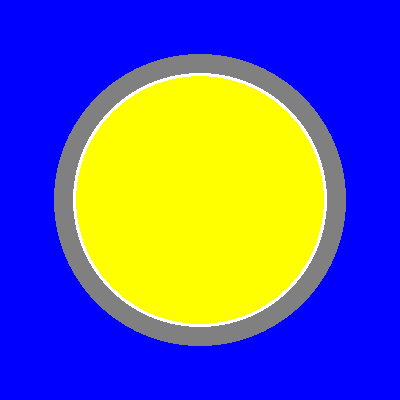

In [11]:
p = openmc.Plot()
p.width = [Pitch,Pitch]
p.pixels = [400,400]
p.origin = [0.0, 0.0, 0.0]
p.color_by = 'material'
p.colors = colors

openmc.plot_inline(p)


Now that the geometry and material composition of the reactor is specified, we need to tell OpenMC what information we hope to get out of the model.  This is done through *tallies*.

### Re-do Geometry with a Finite Pincell

In [12]:
h_core = 300.; 
h_fuel = 200.;

r_fuel = 0.42;
r_pin = 0.45;

P_D = 1.4;

pitch = P_D*2*r_pin;

fuel_temp = 900; # K, guess at fuel temperature
mod_temp = 600; # K, moderator temperature

# fuel cylinder:
fuel_cyl = openmc.model.RightCircularCylinder([0.,0.,-h_fuel/2.],
                                             h_fuel, r_fuel);

fuel.volume = np.pi*(r_fuel**2)*h_fuel;

# pin cylinder
pin_cyl = openmc.model.RightCircularCylinder([0.,0.,-(h_fuel+(r_pin-r_fuel))/2.],
                                            h_fuel+(r_pin-r_fuel)*2.,r_pin);

# pin cell container
core_cell = openmc.model.RectangularParallelepiped(-pitch/2.,pitch/2.,
                                                  -pitch/2.,pitch/2.,
                                                  -h_core/2.,h_core/2.,
                                                  boundary_type='reflective');

fuel_cell = openmc.Cell();
fuel_cell.region = -fuel_cyl
fuel_cell.fill = fuel;
fuel_cell.temperature = fuel_temp;


clad_cell = openmc.Cell();
clad_cell.region = +fuel_cyl & -pin_cyl;
clad_cell.fill = clad;

mod_cell = openmc.Cell();
mod_cell.region = +pin_cyl & -core_cell;
mod_cell.fill = water

root_univ = openmc.Universe();
root_univ.add_cells([fuel_cell,clad_cell,mod_cell]);

geometry = openmc.Geometry();
geometry.root_universe = root_univ;

materials.export_to_xml();
geometry.export_to_xml();


## Tally Specification

In [13]:
# flux energy spectrum in fuel cell
cell_filter = openmc.CellFilter(fuel_cell)

energy_bins = np.logspace(-3,7,num=1001)
energy_filter = openmc.EnergyFilter(values=energy_bins)

flux_tally = openmc.Tally(name='flux')
flux_tally.scores = ['flux']
flux_tally.filters = [cell_filter,energy_filter]


tallies = openmc.Tallies([flux_tally])

tallies.export_to_xml()

## Settings

In [14]:
settings = openmc.Settings()
settings.batches = 300
settings.inactive = 50
settings.particles = 20000

point = openmc.stats.Point((0,0,0))
source = openmc.Source(space=point)

settings.source = source

settings.export_to_xml()

In [15]:
import os

num_threads_des = 12  # set as desired.  Can be useful to ensure you do not take over all the resources for a machine
num_threads = min(os.cpu_count(),num_threads_des); # prevent asking for more threads than OMP_NUM_THREADS

openmc.run(threads = num_threads)

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                #########

      132/1    1.45431    1.43884 +/- 0.00125
      133/1    1.42669    1.43870 +/- 0.00124
      134/1    1.43669    1.43867 +/- 0.00123
      135/1    1.42053    1.43846 +/- 0.00123
      136/1    1.43219    1.43839 +/- 0.00122
      137/1    1.41295    1.43809 +/- 0.00124
      138/1    1.44499    1.43817 +/- 0.00123
      139/1    1.43389    1.43812 +/- 0.00121
      140/1    1.44532    1.43820 +/- 0.00120
      141/1    1.44436    1.43827 +/- 0.00119
      142/1    1.44114    1.43830 +/- 0.00118
      143/1    1.44186    1.43834 +/- 0.00117
      144/1    1.44725    1.43844 +/- 0.00116
      145/1    1.43682    1.43842 +/- 0.00115
      146/1    1.43239    1.43836 +/- 0.00114
      147/1    1.42444    1.43821 +/- 0.00113
      148/1    1.45040    1.43834 +/- 0.00113
      149/1    1.44114    1.43837 +/- 0.00112
      150/1    1.42949    1.43828 +/- 0.00111
      151/1    1.44260    1.43832 +/- 0.00110
      152/1    1.43671    1.43830 +/- 0.00109
      153/1    1.42251    1.43815 

### Access Tally and Plot Flux Spectrum

In [16]:
sp = openmc.StatePoint('statepoint.300.h5')
sp.tallies

{1: Tally
 	ID             =	1
 	Name           =	flux
 	Filters        =	CellFilter, EnergyFilter
 	Nuclides       =	total
 	Scores         =	['flux']
 	Estimator      =	tracklength}

Text(0, 0.5, 'flux [n/cm**2-s]')

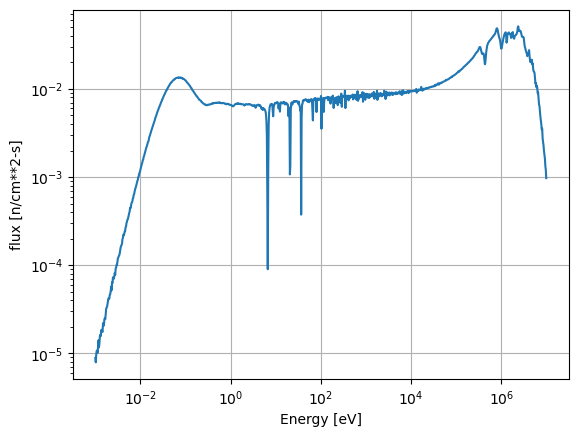

In [17]:
flux = sp.get_tally(name='flux')
flux_df = flux.get_pandas_dataframe()
flux_vals = flux_df['mean'].to_numpy()

energy_x = 0.5*(energy_bins[0:-1]+energy_bins[1:])

plt.loglog(energy_x,flux_vals)
plt.grid()
plt.xlabel('Energy [eV]')
plt.ylabel('flux [n/cm**2-s]')


Notice the deep "pits" in the flux energy distribution.  It is worthwhile to investigate why those features exist.  To do so, more tallies could be added; specifically to measure capture - in total, as well as by specific isotopes. 

In [18]:
sp.close()

## Bonu Section: Depletion

In [19]:
import openmc.deplete

chain = openmc.deplete.Chain.from_xml("chain_endfb71_pwr.xml")


hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


In [20]:
chain.nuclide_dict

OrderedDict([('H1', 0),
             ('H2', 1),
             ('H3', 2),
             ('H4', 3),
             ('H5', 4),
             ('H6', 5),
             ('H7', 6),
             ('He3', 7),
             ('He4', 8),
             ('He5', 9),
             ('He6', 10),
             ('He7', 11),
             ('He8', 12),
             ('He9', 13),
             ('He10', 14),
             ('Li4', 15),
             ('Li5', 16),
             ('Li6', 17),
             ('Li7', 18),
             ('Li8', 19),
             ('Li9', 20),
             ('Li10', 21),
             ('Li11', 22),
             ('Li12', 23),
             ('Be5', 24),
             ('Be6', 25),
             ('Be8', 26),
             ('Be9', 27),
             ('Be10', 28),
             ('Be11', 29),
             ('Be12', 30),
             ('Be13', 31),
             ('Be14', 32),
             ('Be15', 33),
             ('Be16', 34),
             ('B6', 35),
             ('B7', 36),
             ('B8', 37),
             ('B9', 3

In [ ]:
# starting with version 0.13.0, the first argument to an Operator object needs to be a Model
model = openmc.model.Model(geometry, materials, settings);

operator = openmc.deplete.Operator(model,"chain_endfb71_pwr.xml")

power = 1e4;
days = 24*3600; # number of seconds in a day

time_steps = [0.1*days, 0.1*days, 0.1*days, 1.*days, 30*days, 30*days, 180*days]

integrator = openmc.deplete.PredictorIntegrator(operator,time_steps,power)

integrator.integrate()

/home/sblair/miniconda3/envs/openmc-env/lib/python3.9/site-packages/openmc/deplete/coupled_operator.py:542: FutureWarning: The Operator(...) class has been renamed and will be removed in a future version of OpenMC. Use CoupledOperator(...) instead.
  warn(


                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

 Reading Mg24 from /home/sblair/OMC_DATA/endfb71_hdf5/Mg24.h5
 Reading Mg25 from /home/sblair/OMC_DATA/endfb71_hdf5/Mg25.h5
 Reading Mg26 from /home/sblair/OMC_DATA/endfb71_hdf5/Mg26.h5
 Reading Al27 from /home/sblair/OMC_DATA/endfb71_hdf5/Al27.h5
 Reading Si28 from /home/sblair/OMC_DATA/endfb71_hdf5/Si28.h5
 Reading Si29 from /home/sblair/OMC_DATA/endfb71_hdf5/Si29.h5
 Reading Si30 from /home/sblair/OMC_DATA/endfb71_hdf5/Si30.h5
 Reading P31 from /home/sblair/OMC_DATA/endfb71_hdf5/P31.h5
 Reading S32 from /home/sblair/OMC_DATA/endfb71_hdf5/S32.h5
 Reading S33 from /home/sblair/OMC_DATA/endfb71_hdf5/S33.h5
 Reading S34 from /home/sblair/OMC_DATA/endfb71_hdf5/S34.h5
 Reading S36 from /home/sblair/OMC_DATA/endfb71_hdf5/S36.h5
 Reading Cl35 from /home/sblair/OMC_DATA/endfb71_hdf5/Cl35.h5
 Reading Cl37 from /home/sblair/OMC_DATA/endfb71_hdf5/Cl37.h5
 Reading Ar36 from /home/sblair/OMC_DATA/endfb71_hdf5/Ar36.h5
 Reading Ar38 from /home/sblair/OMC_DATA/endfb71_hdf5/Ar38.h5
 Reading Ar40 from

 Reading K41 from /home/sblair/OMC_DATA/endfb71_hdf5/K41.h5
 Reading Ca40 from /home/sblair/OMC_DATA/endfb71_hdf5/Ca40.h5
 Reading Ca42 from /home/sblair/OMC_DATA/endfb71_hdf5/Ca42.h5
 Reading Ca43 from /home/sblair/OMC_DATA/endfb71_hdf5/Ca43.h5
 Reading Ca44 from /home/sblair/OMC_DATA/endfb71_hdf5/Ca44.h5
 Reading Ca46 from /home/sblair/OMC_DATA/endfb71_hdf5/Ca46.h5
 Reading Ca48 from /home/sblair/OMC_DATA/endfb71_hdf5/Ca48.h5
 Reading Sc45 from /home/sblair/OMC_DATA/endfb71_hdf5/Sc45.h5
 Reading Ti46 from /home/sblair/OMC_DATA/endfb71_hdf5/Ti46.h5
 Reading Ti47 from /home/sblair/OMC_DATA/endfb71_hdf5/Ti47.h5
 Reading Ti48 from /home/sblair/OMC_DATA/endfb71_hdf5/Ti48.h5
 Reading Ti49 from /home/sblair/OMC_DATA/endfb71_hdf5/Ti49.h5
 Reading Ti50 from /home/sblair/OMC_DATA/endfb71_hdf5/Ti50.h5
 Reading V50 from /home/sblair/OMC_DATA/endfb71_hdf5/V50.h5
 Reading V51 from /home/sblair/OMC_DATA/endfb71_hdf5/V51.h5
 Reading Cr50 from /home/sblair/OMC_DATA/endfb71_hdf5/Cr50.h5
 Reading Cr52 

 Reading Br81 from /home/sblair/OMC_DATA/endfb71_hdf5/Br81.h5
 Reading Kr78 from /home/sblair/OMC_DATA/endfb71_hdf5/Kr78.h5
 Reading Kr80 from /home/sblair/OMC_DATA/endfb71_hdf5/Kr80.h5
 Reading Kr82 from /home/sblair/OMC_DATA/endfb71_hdf5/Kr82.h5
 Reading Kr83 from /home/sblair/OMC_DATA/endfb71_hdf5/Kr83.h5
 Reading Kr84 from /home/sblair/OMC_DATA/endfb71_hdf5/Kr84.h5
 Reading Kr85 from /home/sblair/OMC_DATA/endfb71_hdf5/Kr85.h5
 Reading Kr86 from /home/sblair/OMC_DATA/endfb71_hdf5/Kr86.h5
 Reading Rb85 from /home/sblair/OMC_DATA/endfb71_hdf5/Rb85.h5
 Reading Rb86 from /home/sblair/OMC_DATA/endfb71_hdf5/Rb86.h5
 Reading Rb87 from /home/sblair/OMC_DATA/endfb71_hdf5/Rb87.h5
 Reading Sr84 from /home/sblair/OMC_DATA/endfb71_hdf5/Sr84.h5
 Reading Sr86 from /home/sblair/OMC_DATA/endfb71_hdf5/Sr86.h5
 Reading Sr87 from /home/sblair/OMC_DATA/endfb71_hdf5/Sr87.h5
 Reading Sr88 from /home/sblair/OMC_DATA/endfb71_hdf5/Sr88.h5
 Reading Sr89 from /home/sblair/OMC_DATA/endfb71_hdf5/Sr89.h5
 Reading

 Reading Mo95 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo95.h5
 Reading Mo96 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo96.h5
 Reading Mo97 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo97.h5
 Reading Mo98 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo98.h5
 Reading Mo99 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo99.h5


 Reading Mo100 from /home/sblair/OMC_DATA/endfb71_hdf5/Mo100.h5
 Reading Tc99 from /home/sblair/OMC_DATA/endfb71_hdf5/Tc99.h5
 Reading Ru96 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru96.h5
 Reading Ru98 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru98.h5
 Reading Ru99 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru99.h5
 Reading Ru100 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru100.h5
 Reading Ru101 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru101.h5
 Reading Ru102 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru102.h5
 Reading Ru103 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru103.h5
 Reading Ru104 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru104.h5
 Reading Ru105 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru105.h5
 Reading Ru106 from /home/sblair/OMC_DATA/endfb71_hdf5/Ru106.h5
 Reading Rh103 from /home/sblair/OMC_DATA/endfb71_hdf5/Rh103.h5
 Reading Rh105 from /home/sblair/OMC_DATA/endfb71_hdf5/Rh105.h5
 Reading Pd102 from /home/sblair/OMC_DATA/endfb71_hdf5/Pd102.h5
 Reading Pd104 from /home/sblair/OMC_DATA/endfb7

          1200K
          2500K


 Reading Cd108 from /home/sblair/OMC_DATA/endfb71_hdf5/Cd108.h5
 Reading Cd110 from /home/sblair/OMC_DATA/endfb71_hdf5/Cd110.h5
 Reading Cd111 from /home/sblair/OMC_DATA/endfb71_hdf5/Cd111.h5
 Reading Cd112 from /home/sblair/OMC_DATA/endfb71_hdf5/Cd112.h5
 Reading Cd113 from /home/sblair/OMC_DATA/endfb71_hdf5/Cd113.h5
 Reading Cd114 from /home/sblair/OMC_DATA/endfb71_hdf5/Cd114.h5
 Reading Cd115_m1 from /home/sblair/OMC_DATA/endfb71_hdf5/Cd115_m1.h5
 Reading Cd116 from /home/sblair/OMC_DATA/endfb71_hdf5/Cd116.h5
 Reading In113 from /home/sblair/OMC_DATA/endfb71_hdf5/In113.h5
 Reading In115 from /home/sblair/OMC_DATA/endfb71_hdf5/In115.h5
 Reading Sn112 from /home/sblair/OMC_DATA/endfb71_hdf5/Sn112.h5
 Reading Sn113 from /home/sblair/OMC_DATA/endfb71_hdf5/Sn113.h5
 Reading Sn114 from /home/sblair/OMC_DATA/endfb71_hdf5/Sn114.h5
 Reading Sn115 from /home/sblair/OMC_DATA/endfb71_hdf5/Sn115.h5
 Reading Sn116 from /home/sblair/OMC_DATA/endfb71_hdf5/Sn116.h5
 Reading Sn117 from /home/sblair/O

          1200K
          2500K


 Reading Sb121 from /home/sblair/OMC_DATA/endfb71_hdf5/Sb121.h5
 Reading Sb123 from /home/sblair/OMC_DATA/endfb71_hdf5/Sb123.h5
 Reading Sb124 from /home/sblair/OMC_DATA/endfb71_hdf5/Sb124.h5
 Reading Sb125 from /home/sblair/OMC_DATA/endfb71_hdf5/Sb125.h5
 Reading Sb126 from /home/sblair/OMC_DATA/endfb71_hdf5/Sb126.h5
 Reading Te120 from /home/sblair/OMC_DATA/endfb71_hdf5/Te120.h5
 Reading Te122 from /home/sblair/OMC_DATA/endfb71_hdf5/Te122.h5
 Reading Te123 from /home/sblair/OMC_DATA/endfb71_hdf5/Te123.h5
 Reading Te124 from /home/sblair/OMC_DATA/endfb71_hdf5/Te124.h5
 Reading Te125 from /home/sblair/OMC_DATA/endfb71_hdf5/Te125.h5


          1200K
          2500K


 Reading Te126 from /home/sblair/OMC_DATA/endfb71_hdf5/Te126.h5
 Reading Te127_m1 from /home/sblair/OMC_DATA/endfb71_hdf5/Te127_m1.h5
 Reading Te128 from /home/sblair/OMC_DATA/endfb71_hdf5/Te128.h5
 Reading Te129_m1 from /home/sblair/OMC_DATA/endfb71_hdf5/Te129_m1.h5
 Reading Te130 from /home/sblair/OMC_DATA/endfb71_hdf5/Te130.h5
 Reading Te132 from /home/sblair/OMC_DATA/endfb71_hdf5/Te132.h5
 Reading I127 from /home/sblair/OMC_DATA/endfb71_hdf5/I127.h5
 Reading I129 from /home/sblair/OMC_DATA/endfb71_hdf5/I129.h5
 Reading I130 from /home/sblair/OMC_DATA/endfb71_hdf5/I130.h5
 Reading I131 from /home/sblair/OMC_DATA/endfb71_hdf5/I131.h5


 Reading I135 from /home/sblair/OMC_DATA/endfb71_hdf5/I135.h5
 Reading Xe123 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe123.h5
 Reading Xe124 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe124.h5
 Reading Xe126 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe126.h5
 Reading Xe128 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe128.h5
 Reading Xe129 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe129.h5
 Reading Xe130 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe130.h5
 Reading Xe131 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe131.h5
 Reading Xe132 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe132.h5
 Reading Xe133 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe133.h5
 Reading Xe134 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe134.h5
 Reading Xe135 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe135.h5
 Reading Xe136 from /home/sblair/OMC_DATA/endfb71_hdf5/Xe136.h5


          2500K


 Reading Cs133 from /home/sblair/OMC_DATA/endfb71_hdf5/Cs133.h5
 Reading Cs134 from /home/sblair/OMC_DATA/endfb71_hdf5/Cs134.h5
 Reading Cs135 from /home/sblair/OMC_DATA/endfb71_hdf5/Cs135.h5
 Reading Cs136 from /home/sblair/OMC_DATA/endfb71_hdf5/Cs136.h5
 Reading Cs137 from /home/sblair/OMC_DATA/endfb71_hdf5/Cs137.h5
 Reading Ba130 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba130.h5
 Reading Ba132 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba132.h5
 Reading Ba133 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba133.h5


          1200K
          2500K


 Reading Ba134 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba134.h5
 Reading Ba135 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba135.h5
 Reading Ba136 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba136.h5
 Reading Ba137 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba137.h5
 Reading Ba138 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba138.h5
 Reading Ba140 from /home/sblair/OMC_DATA/endfb71_hdf5/Ba140.h5
 Reading La138 from /home/sblair/OMC_DATA/endfb71_hdf5/La138.h5
 Reading La139 from /home/sblair/OMC_DATA/endfb71_hdf5/La139.h5
 Reading La140 from /home/sblair/OMC_DATA/endfb71_hdf5/La140.h5
 Reading Ce136 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce136.h5
 Reading Ce138 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce138.h5
 Reading Ce139 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce139.h5
 Reading Ce140 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce140.h5
 Reading Ce141 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce141.h5
 Reading Ce142 from /home/sblair/OMC_DATA/endfb71_hdf5/Ce142.h5
 Reading Ce143 from /home/sblair/OMC_DAT

          1200K
          2500K


 Reading Gd152 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd152.h5
 Reading Gd153 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd153.h5
 Reading Gd154 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd154.h5
 Reading Gd155 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd155.h5
 Reading Gd156 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd156.h5
 Reading Gd157 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd157.h5
 Reading Gd158 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd158.h5
 Reading Gd160 from /home/sblair/OMC_DATA/endfb71_hdf5/Gd160.h5
 Reading Tb159 from /home/sblair/OMC_DATA/endfb71_hdf5/Tb159.h5
 Reading Tb160 from /home/sblair/OMC_DATA/endfb71_hdf5/Tb160.h5
 Reading Dy156 from /home/sblair/OMC_DATA/endfb71_hdf5/Dy156.h5
 Reading Dy158 from /home/sblair/OMC_DATA/endfb71_hdf5/Dy158.h5
 Reading Dy160 from /home/sblair/OMC_DATA/endfb71_hdf5/Dy160.h5
 Reading Dy161 from /home/sblair/OMC_DATA/endfb71_hdf5/Dy161.h5
 Reading Dy162 from /home/sblair/OMC_DATA/endfb71_hdf5/Dy162.h5
 Reading Dy163 from /home/sblair/OMC_DAT

 Reading Cf249 from /home/sblair/OMC_DATA/endfb71_hdf5/Cf249.h5
 Reading Cf250 from /home/sblair/OMC_DATA/endfb71_hdf5/Cf250.h5
 Reading Cf251 from /home/sblair/OMC_DATA/endfb71_hdf5/Cf251.h5
 Reading Cf252 from /home/sblair/OMC_DATA/endfb71_hdf5/Cf252.h5
 Reading Cf253 from /home/sblair/OMC_DATA/endfb71_hdf5/Cf253.h5


          1200K


 Reading Cf254 from /home/sblair/OMC_DATA/endfb71_hdf5/Cf254.h5
 Reading Es251 from /home/sblair/OMC_DATA/endfb71_hdf5/Es251.h5
 Reading Es252 from /home/sblair/OMC_DATA/endfb71_hdf5/Es252.h5
 Reading Es253 from /home/sblair/OMC_DATA/endfb71_hdf5/Es253.h5
 Reading Es254 from /home/sblair/OMC_DATA/endfb71_hdf5/Es254.h5
 Reading Es254_m1 from /home/sblair/OMC_DATA/endfb71_hdf5/Es254_m1.h5
 Reading Es255 from /home/sblair/OMC_DATA/endfb71_hdf5/Es255.h5
 Reading Fm255 from /home/sblair/OMC_DATA/endfb71_hdf5/Fm255.h5
 Maximum neutron transport energy: 20000000 eV for O17
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    1.45268
        2/1    1.43146
        3/1    1.44115
        4/1    1.45276
        5/1    1.44549
        6/1    1.47688
        7/1    1.45467
        8/1    1.44980
        9/1    1.43987
       10/1    1.4571